In [53]:
import hopsworks
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import numpy as np

In [52]:
#ML imports
#import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from sklearn.metrics import mean_squared_error


In [36]:
import datetime
year = datetime.date.today().year
year

2023

In [37]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/224406
Connected. Call `.close()` to terminate connection gracefully.


In [38]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view

valuation_fg = fs.get_feature_group(name="valuationdataset", version=year-2022)
query = valuation_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="valuationdataset_fv",
                                  version=year-2022,
                                  description="Read from valuation dataset",
                                  labels=["market_value_in_eur"],
                                  query=query)

In [40]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)



Finished: Reading data from Hopsworks, using ArrowFlight (1.69s) 


In [41]:
#Drop date column, keeping it because might make sense later

X_train = X_train.drop(columns=["player_id", "date"])
X_test = X_test.drop(columns=["player_id", "date"])

In [57]:
y_train.describe().T

,count,mean,std,min,25%,50%,75%,max
market_value_in_eur,2171.0,1.029809e+07,1.519546e+07,25000.0,1500000.0,4000000.0,12000000.0,120000000.0


AttributeError: 'DataFrame' object has no attribute 'accuracy'

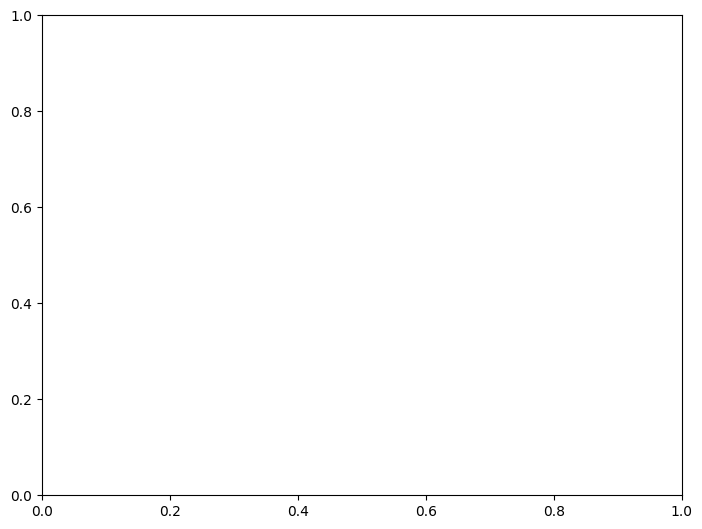

In [60]:
comparisons_df = pd.DataFrame(columns=['model','RSME'])
#model data
gbr = GradientBoostingRegressor(random_state=0)
svr = SVR(kernel="linear",gamma="auto")
dtr = DecisionTreeRegressor(random_state=0)
rfr = RandomForestRegressor(random_state=1)
#cat= CatBoostRegressor(iterations=10,learning_rate=1,depth=3)
#lgbm=LGBMRegressor()

models=[gbr,svr,dtr,rfr]
for model in models:
    model.fit(X_train, y_train)
    #assess accurancy of model
    #comparisons_df.loc[len(comparisons_df)] = [model.__class__.__name__,model.score(X_test, y_test)]
    mse = mean_squared_error(y_test, model.predict(X_test))
    rmse = np.sqrt(mse)  # Calculate the RMSE
    comparisons_df.loc[len(comparisons_df)] = [model.__class__.__name__, rmse]
    
#create barchart to show performances
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = comparisons_df.model
y = comparisons_df.accuracy
ax.bar(x,y)
plt.xticks(fontsize=18, rotation=90)
plt.title('Root mean squared error',fontsize=28)
plt.show()
print(comparisons_df)


